# Solitaire DQN, Pytorch Implementation using FC DNN

## Hardware Check

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 21 08:50:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Imports

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Solitaire Gym Class and Functions

In [4]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.spaces import Tuple, Discrete, MultiDiscrete, Sequence
from gym.error import DependencyNotInstalled

#credit: https://stackoverflow.com/questions/47269390/how-to-find-first-non-zero-value-in-every-column-of-a-numpy-array
def first_nonzero_index(array):
    """Return the index of the first non-zero element of array. If all elements are zero, return -1."""
    
    fnzi = -1 # first non-zero index
    indices = np.flatnonzero(array)
       
    if (len(indices) > 0):
        fnzi = indices[0]
        
    return fnzi

#gets suit number given card num (worried about it always returning 0, shouldnt it be -1?)
def get_suit(card_num):
    if card_num / 13 <= 1:
        return 0
    elif card_num / 26 <= 1:
        return 1
    elif card_num / 39 <= 1:
        return 2
    else:
        return 3
    return 0

#gets suit and card num, given card num
def get_suit_and_num(card_num):
    if card_num == 0 or card_num == 53:
        return [0, card_num]

    suit = 0
    num = card_num % 13
    if num == 0:
        num = 13

    if card_num / 13 <= 1:
        suit = 0
    elif card_num / 26 <= 1:
        suit = 1
    elif card_num / 39 <= 1:
        suit = 2
    else:
        suit = 3

    return [suit, num]

#gets character from the suit (for displaying images)
def get_suit_char_from_val(suit_val):
    if suit_val == 0:
        return "H"
    elif suit_val == 1:
        return "D"
    elif suit_val == 2:
        return "S"
    elif suit_val == 3:
        return "C"

#gets character from the card num (for displaying images)
def get_card_char(card_num):
    if card_num == 1:
        return "A"
    elif card_num == 10:
        return "T"
    elif card_num == 11:
        return "J"
    elif card_num == 12:
        return "Q"
    elif card_num == 13:
        return "K"
    else:
        return str(int(card_num))

#returns an np array size 52 with the numbers 1-53(non-inc), False-resampled
def get_shuffled_deck(np_random):
    return np_random.choice(range(1,53), 52, False)

#checks if can move card from deck to suit
def deck_to_suit_check(deck_cards_param, suit_cards_param, highest_nonzero_deck):
    #-1 is encoded in this variable as the row is entirely empty, so cant move anything from empty deck top row
    if highest_nonzero_deck > -1:
        #make sure it can slot into the pile properly
        active_deck_card = deck_cards_param[0, highest_nonzero_deck]
        active_deck_card_suit_and_num = get_suit_and_num(active_deck_card)
        a_suit = active_deck_card_suit_and_num[0]
        a_num = active_deck_card_suit_and_num[1]
        #if suit cards is one below active deck card number, then can add to suits
        if suit_cards_param[a_suit] + 1 == a_num:
            return True, a_suit
    return False, False

#checks if can move from deck to pile
def deck_to_pile_check(deck_cards_param, pile_cards_param, pile_i, highest_nonzero_deck):
    #-1 is encoded in this variable as the row is entirely empty, so cant move anything from empty deck top row
    if highest_nonzero_deck > -1:
        #get suit and num of the deck card
        c_suit_and_num = get_suit_and_num(deck_cards_param[0, highest_nonzero_deck])
        c_suit = c_suit_and_num[0]
        c_num = c_suit_and_num[1]

        #check if deck card is king, if so just check if pile bottom most is empty
        if c_num == 13:
            if pile_cards_param[0,pile_i] == 0:
                return True
        else:

            #check pile bottom most is not empty
            if pile_cards_param[0, pile_i] > 0:
                
                #check the pile you are trying to move to's bottom most card is one lower and different suit
                t_suit_and_num = get_suit_and_num(pile_cards_param[0,pile_i])
                
                #check opposite suits and current card is one lower than target
                if ((c_suit <= 1 and t_suit_and_num[0] >= 2) or (c_suit >= 2 and t_suit_and_num[0] <= 1)) and (c_num + 1 == t_suit_and_num[1]):
                    return True  

    return False


#checks if can move from suit down to pile
def suit_to_pile_check(suit_cards_param, pile_cards_param, pile_i, suit_j):
    #check suit card you are trying to move exists, i.e. greater than zero
    #and also greater than one because why consider moving ace down?
    c_num = suit_cards_param[suit_j]
    if c_num > 1:
        
        #first, check it isnt a king edge case
        if c_num == 13:
            
            #check if pile trying to move to is empty
            if pile_cards_param[0, pile_i] == 0:
                return True
        
        else:
            
            #check pile bottom most is not empty
            if pile_cards_param[0, pile_i] > 0:
                
                #check the pile you are trying to move to's bottom most card is one lower and different suit
                t_suit_and_num = get_suit_and_num(pile_cards_param[0,pile_i])
                
                #check opposite suits and current card is one lower than target
                if ((suit_j <= 1 and t_suit_and_num[0] >= 2) or (suit_j >= 2 and t_suit_and_num[0] <= 1)) and (c_num + 1 == t_suit_and_num[1]):
                    return True
    
    return False

#check if can move from pile to suit
def pile_to_suit_check(pile_cards_param, suit_cards_param, pile_i):
    #check there is a card in the pile
    if pile_cards_param[0,pile_i] > 0:
        #get suit and number of bottom most pile card
        a_suit_and_num = get_suit_and_num(pile_cards_param[0,pile_i])
        #check that the card is indeed one higher than what is current in its suit
        if a_suit_and_num[1] - 1 == suit_cards_param[a_suit_and_num[0]]:
            return True, a_suit_and_num[0]
    return False, False


#check that agent can move some card index (and all the cards below it) to
#another pile
#index 0 is lowest card
def pile_to_pile_check(pile_cards_param, pile_i, pile_to_move_to_j, card_k, highest_nonzero_pile_i):
    #check current pile is not empty
    if highest_nonzero_pile_i > -1:
        #check that there is a card which is a number 
        #of cards below the top one you want to move
        #i.e. if the pile is ace,2,3,4, and card_k=7, that is out of bounds
        #max would be card_k = 3, which would move ace. card_k = 0 moves card 4
        #only 12 actions because in k,q,j,10,9,8,7,6,5,4,3,2,ace, it would only
        #ever make sense to go down to the 2 and move that, otherwise
        #send the ace to the suits
        #highest nonzero pile i here should be 3
        if card_k <= highest_nonzero_pile_i:
            #get the index of the current card you want to move. In the above example
            #c_k = 3 would mean we move index 0, the ace, exactly. c_k=0 means we move
            #index 3, the 4, exactly
            index_to_move = highest_nonzero_pile_i - card_k
            #get the current top card trying to move's suit and num
            c_suit_and_num = get_suit_and_num(pile_cards_param[index_to_move,pile_i])

            #if the current card we want to move is a king, check the target pile is empty
            if c_suit_and_num[1] == 13:
                if not pile_cards_param[:,pile_to_move_to_j].any():
                    return True
            else:
                #else its some other card, so check the pile we want to move to has
                #card at index 0, and that it is one lower and different suit than current
                if pile_cards_param[0,pile_to_move_to_j] > 0:
                    t_suit_and_num = get_suit_and_num(pile_cards_param[0,pile_to_move_to_j])
                    #check diff suit and one higher
                    if ((c_suit_and_num[0] <= 1 and t_suit_and_num[0] >= 2) or (c_suit_and_num[0] >= 2 and t_suit_and_num[0] <= 1)) and (c_suit_and_num[1] + 1 == t_suit_and_num[1]):
                        return True

    return False


#solitaire world environment class
class SolitaireWorldEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.render_mode = render_mode

        #Remember, obs are only thing agent can see. Other self... things can
        #exist but not be in here, to manage underlying but unknown-to-agent state

        #8 decks to flip thru, 3 cards in a deck, can be 53 (when it initializes and
        #agent hasn't flipped through, but once it has just becomes 0-52 I guess
        decks_obs_shape = np.zeros((8,3), dtype=np.int8)
        decks_obs_shape.fill(54)
        #13 possible cards in a pile, 7 piles, 0 unknown, 1-52 card
        piles_obs_shape = np.zeros((13,7), dtype=np.int8)
        piles_obs_shape.fill(53)
        #piles behind has 7 piles, with as many as 6 cards behind
        piles_behind_obs_shape = np.zeros((6,7), dtype=np.int8)
        piles_behind_obs_shape.fill(54)

        piles_behind_actual_obs_shape = np.zeros((6,7), dtype=np.int8)
        piles_behind_actual_obs_shape.fill(53)

        self.action_space = Discrete(548)
        self.observation_space = spaces.Dict({
            "deck_position": Discrete(8),
            "decks_actual": MultiDiscrete(decks_obs_shape), #for testing
            "decks": MultiDiscrete(decks_obs_shape),
            "suits": MultiDiscrete(np.array([14,14,14,14])),
            "piles": MultiDiscrete(piles_obs_shape),
            "piles_behind": MultiDiscrete(piles_behind_obs_shape), #6 possible cards behind
            "piles_behind_actual": MultiDiscrete(piles_behind_actual_obs_shape) #for testing
        })


        self.render_mode = render_mode

    #returns array of 0s and 1s, of length num actions,
    #where if the value at the index in the array for the action is 1
    #the action is valid
    def action_mask(self, deck_cards_p, suit_cards_p, pile_cards_p):
        mask = np.zeros(548, dtype=np.int8)
        #can always tap the deck
        mask[0] = 1
        #gets the highest nonzero index by rows, for the first row of the deck array
        #credit: https://stackoverflow.com/questions/67921398/find-the-index-of-last-non-zero-value-per-column-of-a-2-d-array
        #deck first nonzero, obviously we only care about row 0, hence [0] at end
        highest_nonzero_deck_am = np.where(np.count_nonzero(deck_cards_p, axis=1)==0, -1, (deck_cards_p.shape[1]-1) - np.argmin(deck_cards_p[:,::-1]==0, axis=1))[0]
        #need highest nonzero, since needed for checking pile to pile actions
        highest_nonzeros_piles_am = np.where(np.count_nonzero(pile_cards_p, axis=0)==0, -1, (pile_cards_p.shape[0]-1) - np.argmin(pile_cards_p[::-1,:]==0, axis=0))

        #for each action, besides 0 because always possible to tap deck
        for i in range(1,548):
            if i == 1:
                can_deck_to_suit, _ = deck_to_suit_check(deck_cards_p, suit_cards_p, highest_nonzero_deck_am)
                if can_deck_to_suit:
                    mask[i] = 1

            elif i >= 2 and i <= 8:
                p_i = i - 2
                can_deck_to_pile = deck_to_pile_check(deck_cards_p, pile_cards_p, p_i, highest_nonzero_deck_am)
                if can_deck_to_pile:
                    mask[i] = 1

            elif i >= 9 and i <= 36:
                p_i = (i - 9) % 7
                s_j = (i - 9) // 7
                can_suit_to_pile = suit_to_pile_check(suit_cards_p, pile_cards_p, p_i, s_j)
                if can_suit_to_pile:
                    mask[i] = 1

            elif i >= 37 and i <= 43:
                p_i = (i - 37)
                can_pile_to_suit, _ = pile_to_suit_check(pile_cards_p, suit_cards_p, p_i)
                if can_pile_to_suit:
                    mask[i] = 1

            elif i >= 44 and i <= 547:
                p_i = (i - 44) // 72
                p_to_m = int(((i - 44 - (72*p_i)) // 12) + 1)
                p_to_m_j = (p_i + p_to_m) % 7
                c_k = (i - 44) % 12
                can_pile_to_pile = pile_to_pile_check(pile_cards_p, p_i, p_to_m_j, c_k, highest_nonzeros_piles_am[p_i])
                if can_pile_to_pile:
                    mask[i] = 1

        return mask

    #gym step func
    def step(self, action):
        assert self.action_space.contains(action)

        terminated = False
        #game reward for initial part of step starts at zero, changes depending on action outcome
        game_reward = 0
        #agent reward however is -1 because we want to penalize it for steping, since time is a factor
        reward = 0

        #source: https://en.wikipedia.org/wiki/Klondike_(solitaire) Microsoft Windows Scoring section
        game_score_deck_to_pile = 5
        game_score_deck_to_suit = 10
        game_score_pile_to_suit = 10
        game_score_pile_card_reveal = 5
        game_score_suit_to_pile = -15
        game_score_deck_cycle = -20
        game_score_victory = 10000

        agent_reward_deck_to_pile = 1
        agent_reward_deck_to_suit = 2
        agent_reward_pile_to_suit = 1
        agent_reward_pile_to_pile = -0.5
        agent_reward_pile_card_reveal = 0.5
        agent_reward_suit_to_pile = -1.5
        agent_reward_deck_cycle = 0
        agent_reward_deck_flip = 0
        agent_reward_victory = 1


        #action 0 is tapping deck
        if action == 0:
            #append first row to end, for underlying and known sets
            self.deck_cards = np.append(self.deck_cards, [self.deck_cards[0,:]], axis=0)
            self.deck_cards_known = np.append(self.deck_cards_known, [self.deck_cards_known[0,:]], axis=0)
            #then delete first row for both
            self.deck_cards = np.delete(self.deck_cards, (0), axis=0)
            self.deck_cards_known = np.delete(self.deck_cards_known, (0), axis=0)
            #and copy the top row of deck cards to deck cards known, since we know it now
            self.deck_cards_known[0,:] = self.deck_cards[0,:]

            if self.deck_position == 7:
                #flatten, put zeros at end, reshape
                #part of rules to how deck works, weird
                flat_deck = self.deck_cards.flatten()
                #count occurances of 0's
                num_zeros = np.count_nonzero(flat_deck == 0)
                #remove zeros
                flat_deck_no_zeros = np.delete(flat_deck, np.where(flat_deck == 0), axis = -1)
                #add them to end
                flat_deck_zeros = np.append(flat_deck_no_zeros, np.zeros(num_zeros, dtype=np.int8), axis = -1)
                #update state
                self.deck_cards = flat_deck_zeros.reshape((8,3))
                #at this point, since we have cycled through, we now have complete information and can just copy
                self.deck_cards_known = self.deck_cards
                self.deck_position = 0
                #no reward, unless its the 7th
                game_reward += game_score_deck_cycle
                reward += agent_reward_deck_cycle
            else:
                reward += agent_reward_deck_flip
                #increase deck position (so to know when to reset deck and penalize)
                self.deck_position = self.deck_position + 1
        
        #action 1 is tapping active deck card, attempting to sent to suit
        elif action == 1:
            highest_nonzero_deck = np.where(np.count_nonzero(self.deck_cards, axis=1)==0, -1, (self.deck_cards.shape[1]-1) - np.argmin(self.deck_cards[:,::-1]==0, axis=1))[0]
            can_deck_to_suit, deck_card_suit = deck_to_suit_check(self.deck_cards, self.suit_cards, highest_nonzero_deck)
            if can_deck_to_suit:
                #update suit cards
                self.suit_cards[deck_card_suit] = self.suit_cards[deck_card_suit] + 1
                #set card val to 0 for empty at the given index
                self.deck_cards[0,highest_nonzero_deck] = 0
                self.deck_cards_known[0,highest_nonzero_deck] = 0
                game_reward += agent_reward_deck_to_suit
                reward += agent_reward_deck_to_suit

                #check if terminal/goal state, all suits at king
                if self.suit_cards[0] == 13 and self.suit_cards[1] == 13 and self.suit_cards[2] == 13 and self.suit_cards[3] == 13:
                    print("VICTORY!")
                    print(self.suit_cards)
                    terminated = True
                    game_reward += game_score_victory
                    reward += agent_reward_victory
    
        #actions 2-8 are trying to move top deck card to one of 7 other piles
        elif action >= 2 and action <= 8:
            pile_i = action - 2
            highest_nonzero_deck = np.where(np.count_nonzero(self.deck_cards, axis=1)==0, -1, (self.deck_cards.shape[1]-1) - np.argmin(self.deck_cards[:,::-1]==0, axis=1))[0]

            can_deck_to_pile = deck_to_pile_check(self.deck_cards, self.pile_cards, pile_i, highest_nonzero_deck)      
            if can_deck_to_pile:
                #shift all cards one index up to make room for this at bottom (index 0)
                self.pile_cards[1:,pile_i] = self.pile_cards[:-1,pile_i]
                #set bottom most index card to be the one we added, since we can now
                self.pile_cards[0,pile_i] = self.deck_cards[0,highest_nonzero_deck]

                #set deck card val to 0 for empty at the given index
                self.deck_cards[0,highest_nonzero_deck] = 0
                self.deck_cards_known[0,highest_nonzero_deck] = 0

                #deck to pile rewards
                game_reward += game_score_deck_to_pile
                reward += agent_reward_deck_to_pile
        
        #actions 9-15 are trying to move suit's 0 (hearts) to one of 7 other piles
        #actions 16-22 are trying to move suit's 1 (diamonds) to one of 7 other piles
        #...etc
        elif action >= 9 and action <= 36:
            pile_i = (action - 9) % 7
            suit_j = (action - 9) // 7

            can_suit_to_pile = suit_to_pile_check(self.suit_cards, self.pile_cards, pile_i, suit_j)

            if can_suit_to_pile:
                #shift pile cards up, to make room for suit card to add
                self.pile_cards[1:,pile_i] = self.pile_cards[:-1,pile_i]
                #set bottom most index card to be the one we added, since we can now
                #have to multiply by suit_j*13 to get original card val back from suit and num
                self.pile_cards[0,pile_i] = int((suit_j * 13) + self.suit_cards[suit_j])

                #reduce suit card val, since we took a card off it
                self.suit_cards[suit_j] -= 1

                #suit to pile rewards (negative)
                game_reward += game_score_suit_to_pile
                reward += agent_reward_suit_to_pile
       
        #actions 37-43 are trying to move bottom-most card in one of 7 piles
        #to their given suits
        elif action >= 37 and action <= 43:
            pile_i = (action - 37)

            can_pile_to_suit, pile_card_suit = pile_to_suit_check(self.pile_cards, self.suit_cards, pile_i)

            if can_pile_to_suit:
                #update suit cards
                self.suit_cards[pile_card_suit] += 1

                #update pile cards
                #(set cards from beginning to one from end to the cards from 1 to end)
                self.pile_cards[:-1,pile_i] = self.pile_cards[1:,pile_i]
                #and set end card to 0, since we removed a card from the pile
                self.pile_cards[-1,pile_i] = 0

                #pile to suit reward
                game_reward += game_score_pile_to_suit
                reward += agent_reward_pile_to_suit

                #check if the pile is now empty, and there are upside-down cards behind it
                #if so, turn it up and add it to correct spot in pile_cards
                if not self.pile_cards[:,pile_i].any():
                    #get highest nonzero for pile behind card
                    highest_nonzeros_piles_behind = np.where(np.count_nonzero(self.pile_behind_cards, axis=0)==0, -1, (self.pile_behind_cards.shape[0]-1) - np.argmin(self.pile_behind_cards[::-1,:]==0, axis=0))[pile_i]
                    if highest_nonzeros_piles_behind > -1:
                        self.pile_cards[0, pile_i] = self.pile_behind_cards[highest_nonzeros_piles_behind,pile_i]
                        self.pile_behind_cards[highest_nonzeros_piles_behind, pile_i] = 0
                        self.pile_behind_cards_known[highest_nonzeros_piles_behind, pile_i] = 0
                        game_reward += game_score_pile_card_reveal
                        reward += agent_reward_pile_card_reveal      

                #check if terminal/goal state, all suits at king
                if self.suit_cards[0] == 13 and self.suit_cards[1] == 13 and self.suit_cards[2] == 13 and self.suit_cards[3] == 13:
                    print("VICTORY!")
                    print(self.suit_cards)
                    terminated = True
                    game_reward += game_score_victory
                    reward += agent_reward_victory

        #actions 44 to 547 are pile to pile moves, defined by the vars below
        elif action >= 44 and action <= 547:
            pile_i = (action - 44) // 72
            piles_to_move = int(((action - 44 - (72*pile_i)) // 12) + 1)
            #print("piles to move: ", piles_to_move)
            pile_to_move_to_j = (pile_i + piles_to_move) % 7
            card_k = (action - 44) % 12

            highest_nonzeros_piles = np.where(np.count_nonzero(self.pile_cards, axis=0)==0, -1, (self.pile_cards.shape[0]-1) - np.argmin(self.pile_cards[::-1,:]==0, axis=0))
            highest_nonzero_pile_i = highest_nonzeros_piles[pile_i]
            can_pile_to_pile = pile_to_pile_check(self.pile_cards, pile_i, pile_to_move_to_j, card_k, highest_nonzero_pile_i)

            if can_pile_to_pile:
                #if can pile to pile,
                #card_k = 0, highest_nonzero_pile_i = 4, we are moving 4 cards to pile j, and these cards go under the others at pile j
                #so pile j needs to shift cards up by highest_nzpi - c_k, i.e. 4
                #+1 because ...?
                reward += agent_reward_pile_to_pile

                index_to_move = highest_nonzero_pile_i - card_k + 1

                #first, shift cards up
                self.pile_cards[index_to_move:,pile_to_move_to_j] = self.pile_cards[:(13 - index_to_move),pile_to_move_to_j]
                #then add in cards from pile i
                self.pile_cards[:index_to_move,pile_to_move_to_j] = self.pile_cards[:index_to_move,pile_i]
                #finally shift pile i cards down
                self.pile_cards[:(13 - index_to_move),pile_i] = self.pile_cards[index_to_move:,pile_i]
                #and zero out rest of pile
                self.pile_cards[(13 - index_to_move):,pile_i] = 0 

                #if pile is now empty that we removed some cards, i.e. we removed top card because card k is 0, meaning no cards below it selected as top
                if card_k == 0:
                    #get highest nonzero for pile behind card
                    highest_nonzeros_piles_behind = np.where(np.count_nonzero(self.pile_behind_cards, axis=0)==0, -1, (self.pile_behind_cards.shape[0]-1) - np.argmin(self.pile_behind_cards[::-1,:]==0, axis=0))[pile_i]
                    if highest_nonzeros_piles_behind > -1:
                        self.pile_cards[0, pile_i] = self.pile_behind_cards[highest_nonzeros_piles_behind,pile_i]
                        self.pile_behind_cards[highest_nonzeros_piles_behind, pile_i] = 0
                        self.pile_behind_cards_known[highest_nonzeros_piles_behind, pile_i] = 0
                        game_reward += game_score_pile_card_reveal
                        reward += agent_reward_pile_card_reveal

        self.game_episode_rewards += game_reward
        self.agent_episode_rewards += reward
        #try if agent rewards get too low, just terminate
        self.episode_steps += 1
        if self.episode_steps > 500:
            terminated = True

        if self.render_mode == "human":
            self.render()
        # return self._get_obs(), reward, terminated, False, {"action_mask": self.action_mask(self.deck_cards, self.suit_cards, self.pile_cards)}
        return self._get_obs(), reward, terminated, {"action_mask": self.action_mask(self.deck_cards, self.suit_cards, self.pile_cards)}


    def _get_obs(self):
        return {
            "deck_position": self.deck_position,
            "decks_actual": self.deck_cards,
            "decks": self.deck_cards_known,
            "suits": self.suit_cards,
            "piles": self.pile_cards,
            "piles_behind": self.pile_behind_cards_known,
            "piles_behind_actual": self.pile_behind_cards
        }
        #return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)

        shuffled_deck = get_shuffled_deck(self.np_random)

        self.game_episode_rewards = 0
        self.agent_episode_rewards = 0
        self.episode_steps = 0

        self.deck_cards = shuffled_deck[:24].reshape((8,3))
        self.deck_cards_known = np.zeros((8,3), dtype=np.int8)
        self.deck_cards_known.fill(53)
        self.deck_cards_known[0,:] = self.deck_cards[0,:]
        #testing
        # self.deck_cards[0,2] = 9
        # self.deck_cards_known[0,2] = 9
        # self.deck_cards[0,1] = 15
        # self.deck_cards_known[0,1] = 15
        # self.deck_cards[0,0] = 28
        # self.deck_cards_known[0,0] = 28

        self.deck_position = 0

        self.suit_cards = np.zeros(4, dtype=np.int8)
        #testing
        # self.suit_cards[0] = 3
        # self.suit_cards[1] = 3
        # self.suit_cards[2] = 3
        # self.suit_cards[3] = 3

        #NOTE: SHOULD try to MAKE THIS MORE EFFICIENT
        self.pile_cards = np.zeros((13,7), dtype=np.int8)
        self.pile_behind_cards_known = np.zeros((6,7), dtype=np.int8)
        self.pile_behind_cards = np.zeros((6,7), dtype=np.int8)
        card_index = 24
        for i in range(7):
            bottom_pile_card = get_suit_and_num(shuffled_deck[card_index])
            self.pile_cards[0,i] = shuffled_deck[card_index]
            card_index += 1

            for j in range(i):
                self.pile_behind_cards_known[j,i] = 53
                self.pile_behind_cards[j,i] = shuffled_deck[card_index]
                card_index += 1

        #testing
        # self.pile_cards[0,0] = 0
        # self.pile_cards[1,0] = 0
        # self.pile_cards[2,0] = 0
        # self.pile_cards[3,0] = 0
        # self.pile_cards[4,0] = 0
        # self.pile_cards[5,0] = 0
        # self.pile_cards[6,0] = 0
        # self.pile_cards[7,0] = 0
        # self.pile_cards[8,0] = 0
        # self.pile_cards[9,0] = 0
        # self.pile_cards[10,0] = 0
        # self.pile_cards[11,0] = 0
        # self.pile_cards[12,0] = 0

        # self.pile_cards[0,1] = 33
        # self.pile_cards[1,1] = 8
        # self.pile_cards[2,1] = 35
        # self.pile_cards[3,1] = 10
        # self.pile_cards[4,1] = 0
        # self.pile_cards[5,1] = 0
        # self.pile_cards[6,1] = 0
        # self.pile_cards[7,1] = 0
        # self.pile_cards[8,1] = 0
        # self.pile_cards[9,1] = 0
        # self.pile_cards[10,1] = 0
        # self.pile_cards[11,1] = 0
        # self.pile_cards[12,1] = 0

        # self.pile_behind_cards[0,1] = 0
        # self.pile_behind_cards_known[0,1] = 0

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {"action_mask": self.action_mask(self.deck_cards, self.suit_cards, self.pile_cards)}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        #player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 1200, 640
        card_img_height = screen_height // 4
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname('/content/')
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname('/content/')
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )

        score_text = small_font.render(
            "Score: " + str(self.game_episode_rewards), True, white
        )
        score_text_rect = self.screen.blit(score_text, (spacing, 0))

        reward_text = small_font.render(
            "Reward: " + str(self.agent_episode_rewards), True, white
        )
        reward_text_rect = self.screen.blit(reward_text, (screen_width // 2, 0))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))


        #UPSIDE DOWN DECK CARD
        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                0,
                score_text_rect.bottom + spacing,
            ),
        )
        #DECK CARDS
        if self.deck_cards[0,0] > 0:
            deck_card_one_suit_and_num = get_suit_and_num(self.deck_cards[0,0])
            deck_card_one_suit_char = get_suit_char_from_val(deck_card_one_suit_and_num[0])
            deck_card_one_num_char = get_card_char(deck_card_one_suit_and_num[1])
            deck_card_one_img = scale_card_img(
                get_image(
                    os.path.join(
                        "img",
                        f"{deck_card_one_suit_char}{deck_card_one_num_char}.png",
                    )
                )
            )
            deck_card_one_rect = self.screen.blit(
                deck_card_one_img,
                (
                    card_img_width + spacing,
                    score_text_rect.bottom + spacing,
                ),
            )

        if self.deck_cards[0,1] > 0:
            deck_card_two_suit_and_num = get_suit_and_num(self.deck_cards[0,1])
            deck_card_two_suit_char = get_suit_char_from_val(deck_card_two_suit_and_num[0])
            deck_card_two_num_char = get_card_char(deck_card_two_suit_and_num[1])
            deck_card_two_img = scale_card_img(
                get_image(
                    os.path.join(
                        "img",
                        f"{deck_card_two_suit_char}{deck_card_two_num_char}.png",
                    )
                )
            )
            deck_card_two_rect = self.screen.blit(
                deck_card_two_img,
                (
                    1.5*card_img_width + spacing,
                    score_text_rect.bottom + spacing,
                ),
            )

        if self.deck_cards[0,2] > 0:
            deck_card_three_suit_and_num = get_suit_and_num(self.deck_cards[0,2])
            deck_card_three_suit_char = get_suit_char_from_val(deck_card_three_suit_and_num[0])
            deck_card_three_num_char = get_card_char(deck_card_three_suit_and_num[1])
            deck_card_three_img = scale_card_img(
                get_image(
                    os.path.join(
                        "img",
                        f"{deck_card_three_suit_char}{deck_card_three_num_char}.png",
                    )
                )
            )
            deck_card_three_rect = self.screen.blit(
                deck_card_three_img,
                (
                    2*card_img_width + spacing,
                    score_text_rect.bottom + spacing,
                ),
            )


        #SUIT CARDS
        if self.suit_cards[3] > 0:
            suit_card_four_suit_char = get_suit_char_from_val(3)
            suit_card_four_num_char = get_card_char(self.suit_cards[3])
            suit_card_four_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
            if suit_card_four_suit_char != "Card":
                suit_card_four_img = scale_card_img(
                    get_image(
                        os.path.join(
                            "img",
                            f"{suit_card_four_suit_char}{suit_card_four_num_char}.png",
                        )
                    )
                )
            self.screen.blit(
                suit_card_four_img,
                (
                    screen_width - card_img_width,
                    score_text_rect.bottom + spacing,
                ),
            )

        if self.suit_cards[2] > 0:
            suit_card_three_suit_char = get_suit_char_from_val(2)
            suit_card_three_num_char = get_card_char(self.suit_cards[2])
            suit_card_three_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
            if suit_card_three_suit_char != "Card":
                suit_card_three_img = scale_card_img(
                    get_image(
                        os.path.join(
                            "img",
                            f"{suit_card_three_suit_char}{suit_card_three_num_char}.png",
                        )
                    )
                )
            self.screen.blit(
                suit_card_three_img,
                (
                    screen_width - 2*card_img_width,
                    score_text_rect.bottom + spacing,
                ),
            )

        if self.suit_cards[1] > 0:
            suit_card_two_suit_char = get_suit_char_from_val(1)
            suit_card_two_num_char = get_card_char(self.suit_cards[1])
            suit_card_two_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
            if suit_card_two_suit_char != "Card":
                suit_card_two_img = scale_card_img(
                    get_image(
                        os.path.join(
                            "img",
                            f"{suit_card_two_suit_char}{suit_card_two_num_char}.png",
                        )
                    )
                )
            self.screen.blit(
                suit_card_two_img,
                (
                    screen_width - 3*card_img_width,
                    score_text_rect.bottom + spacing,
                ),
            )

        if self.suit_cards[0] > 0:
            suit_card_one_suit_char = get_suit_char_from_val(0)
            suit_card_one_num_char = get_card_char(self.suit_cards[0])
            suit_card_one_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
            if suit_card_one_suit_char != "Card":
                suit_card_one_img = scale_card_img(
                    get_image(
                        os.path.join(
                            "img",
                            f"{suit_card_one_suit_char}{suit_card_one_num_char}.png",
                        )
                    )
                )
            self.screen.blit(
                suit_card_one_img,
                (
                    screen_width - 4*card_img_width,
                    score_text_rect.bottom + spacing,
                ),
            )


        #PILE CARDS

        for i in range(int(self.pile_cards.shape[1])):
            spacing_counter = 0
            #place behind cards
            for j in range(6):
                if self.pile_behind_cards[j,i] != 0:
                    pile_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
                    self.screen.blit(
                        pile_card_img,
                        (
                            i * (card_img_width + 50),
                            (screen_height // 2.75) + (spacing // 2) + spacing_counter,
                        ),
                    )
                    spacing_counter += 10

            for j in range(12,-1,-1):
                if self.pile_cards[j,i] > 0:
                    pile_card_suit_and_num = get_suit_and_num(self.pile_cards[j,i])
                    pile_card_suit_char = get_suit_char_from_val(pile_card_suit_and_num[0])
                    pile_card_num_char = get_card_char(pile_card_suit_and_num[1])
                    #pile_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
                    #if pile_card_suit_char != "Card":
                    pile_card_img = scale_card_img(
                        get_image(
                            os.path.join(
                                "img",
                                f"{pile_card_suit_char}{pile_card_num_char}.png",
                            )
                        )
                    )
                    self.screen.blit(
                        pile_card_img,
                        (
                            i * (card_img_width + 50),
                            (screen_height // 2.75) + (spacing // 2) + spacing_counter,
                        ),
                    )
                    spacing_counter += 30


        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )


    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


## DQN class

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Replay Memory class
credit Pytorch official docs

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Matplotlib Setup

In [7]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Hyperparameters, initialization variables

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.5
EPS_START = 0.9
EPS_END = 0.15
# EPS_DECAY = 50000 #0.2 around 220
EPS_DECAY = 10000 #0.1 around 140, #0.05 around 140
TAU = 0.001
LR = 1e-5
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Instantiate Solitaire Gym environment

In [9]:
env = SolitaireWorldEnv()
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
if gym.__version__[:4] == '0.26':
    state, _ = env.reset()
elif gym.__version__[:4] == '0.25':
    state, _ = env.reset()

### Define functions to get suit and card number, vectorized

In [10]:
def get_suit_val(card_param):
    if card_param == 0:
        return 0
    elif card_param == 53:
        return -1
    
    if card_param / 13 <= 1:
        return 1
    elif card_param / 26 <= 1:
        return 2
    elif card_param / 39 <= 1:
        return 3
    else:
        return 4

In [11]:
def get_card_val(card_p):
    if card_p == 0:
        return 0
    elif card_p == 53:
        return -1

    if card_p % 13 == 0:
        return 13
    else:
        return card_p % 13

In [12]:
suit_val_vec = np.vectorize(get_suit_val)
card_val_vec = np.vectorize(get_card_val)

### Define observation from Solitaire gym env, and properties

In [13]:
def get_obs(obs):
    deck_num = obs["deck_position"]
    suits = obs['suits']
    #first 2 rows, all columns of deck
    decks = obs['decks_actual'].flatten()
    decks_suits = suit_val_vec(decks)
    decks_card_vals = card_val_vec(decks)
    piles = obs['piles'].flatten()
    piles_suits = suit_val_vec(piles)
    piles_card_vals = card_val_vec(piles)
    piles_behind = (obs['piles_behind'] != 0).sum(0)
    return np.concatenate((np.array([deck_num]),suits,decks_suits,decks_card_vals,piles_suits,piles_card_vals,piles_behind))

In [14]:
state = get_obs(state)

In [15]:
n_observations = len(state)

In [16]:
n_observations

242

## Instaniate Policy and Target DQN networks, and replay memory buffer

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [18]:
policy_net = DQN(n_observations, n_actions).to(device)
#my, set weights to 0 because could be messing with fact legal actions are sparse?
# policy_net.apply(init_weights)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

## Define select_action function, for epsilon-greedy action selection

In [19]:
def my_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [20]:
def select_action(state, legal_actions):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            q_legal_max = None
            if eps_threshold < EPS_END + 0.001:
                q_vals_all_actions = policy_net(state)[0]
                q_vals_legal_actions = q_vals_all_actions[legal_actions]
                # through experimentation, found adding dirichlet noise
                # actually helps add some randomness in this environment
                # which can suffer from getting stuck in loops
                noise = np.random.dirichlet([5] * q_vals_legal_actions.size()[0])
                # this value was experimentally found to work well with params
                noise = noise * 2
 
                q_vals_legal_with_noise = q_vals_legal_actions + torch.tensor(noise).to("cuda:0")

                q_with_noise_max = q_vals_legal_with_noise.max(0)

                q_with_noise_max_index = q_with_noise_max[1].cpu().numpy()

                q_legal_max = float(q_vals_legal_actions[q_with_noise_max_index])
            else:
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                # get all q values
                q_vals_all_actions = policy_net(state)[0]
                # subset tensor of just legal actions
                q_vals_legal_actions = q_vals_all_actions[legal_actions]
                # get max (value, to check for index in orig later)
                # of legal actions tensor
                q_legal_max = float(q_vals_legal_actions.max(0)[0].cpu().numpy())

            max_val_tensor = (q_vals_all_actions == q_legal_max).nonzero(as_tuple=True)[0]
            if max_val_tensor.size()[0] > 1:
                for i in range(max_val_tensor.size()[0]):
                    #check if index 0 matches any in q_vals_legal_actions
                    if int(max_val_tensor[i].cpu().numpy()) in legal_actions:
                        return torch.tensor([[int(max_val_tensor[i].cpu().numpy())]], device=device, dtype=torch.long)
            return max_val_tensor.view(1,1)
    else:
        return torch.tensor([[np.random.choice(legal_actions,1)[0]]], device=device, dtype=torch.long)

In [21]:
observation, info = env.reset()
observation = get_obs(observation)
inf_legal_actions = info['action_mask'].nonzero()[0]

In [22]:
print(inf_legal_actions)

[  0  42 188]


In [23]:
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

In [24]:
hmm = select_action(observation, inf_legal_actions)

In [25]:
hmm

tensor([[188]], device='cuda:0')

## Define plot function, initialize episode duration/score history array

In [26]:
episode_durations = []

In [27]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Define optimize_model function for performing a gradient update step

In [28]:
#define input tuple for a batch of transitions from the replay memory buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'info_action_mask'))

In [29]:
#performs gradient update step
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    mask_batch = torch.cat([s for i, s in enumerate(batch.info_action_mask) if batch.next_state[i] is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        #get all the q values from the target net for nonfinal states
        target_all_nonfinal_qs = target_net(non_final_next_states)
        #multiply it by the boolean legal action mask for this next state
        #note, the size is still the same, it's just illegal ones now
        #are set to zero, via the multiplication over the same shaped
        #boolean mask, mask_batch
        target_legal_nonfinal_qs = torch.mul(target_all_nonfinal_qs, mask_batch)
        # my_test_after_mul = torch.mul(my_test, mask_batch)
        # print("multiply: ", my_test_after_mul)
        # my_test_after_mul[my_test_after_mul == 0] = float('-inf')
        #set 0s to -inf, because zero could be the highest and it could
        #be an illegal action and we dont want that. Sometimes an action
        #will have only negative reward, and if we leave them as zeros
        #that will become max
        target_legal_nonfinal_qs[target_legal_nonfinal_qs == 0] = float('-inf')

        next_state_values[non_final_mask] = target_legal_nonfinal_qs.max(1)[0]
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 0.5)
    optimizer.step()

## Execute DQN algorithm, continuously plotting rewards

Complete


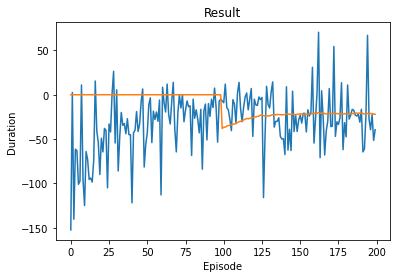

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 100

for i_episode in range(num_episodes):
    #my
    episode_reward = 0
    # Initialize the environment and get it's state
    if gym.__version__[:4] == '0.26':
        state, info = env.reset()
    elif gym.__version__[:4] == '0.25':
        state, info = env.reset()
    state = get_obs(state)
    info_legal_actions = info['action_mask'].nonzero()[0]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state, info_legal_actions)
        observation, reward, terminated, info = env.step(action.item())
        #my
        observation = get_obs(observation)
        info_legal_actions = info['action_mask'].nonzero()[0]
        episode_reward += reward

        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward, torch.tensor(info['action_mask'], device=device, dtype=torch.bool).view(1,-1))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if done:
            episode_durations.append(episode_reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [31]:
torch.save(policy_net.state_dict(), "pointfivegammathreenoise.pt")

# Record and watch video

In [32]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install gym[toy_text]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 990 kB of archives.
After this operation, 3,058 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu1 [12.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-utils amd64 7.7+5 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 xvfb amd64 2:1.20.13-1ubuntu1~20.04.6 [780 kB]
Fetched 990 kB in 0s (2,751 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 128126

In [33]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
_ = display.start()

In [34]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [44]:
vid_path = "solitaire_dqn.mp4"
env = SolitaireWorldEnv(render_mode="rgb_array")

video = VideoRecorder(env, vid_path)


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [45]:
for i in range(1):
    print("episode", i)
    observation, info = env.reset()
    state = get_obs(observation)
    info_legal_actions = info['action_mask'].nonzero()[0]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    terminated = None
    truncated = None

    while not terminated:
        action = select_action(state, info_legal_actions)

        env.render()
        video.capture_frame()

        observation, reward, terminated, info = env.step(action.item())

        observation = get_obs(observation)
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        info_legal_actions = info['action_mask'].nonzero()[0]

video.close()
env.close()

episode 0
VICTORY!
[13 13 13 13]


In [46]:
from IPython.display import HTML
html = render_mp4(vid_path)
HTML(html)